In [176]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

lambda_ = 0.05
delta_t = 1
beta = 1     
k = 1         


M=50
m=4
num_trajectories = 300  # Number of trajectories


def s(j,delta_t,s_0):
    mean=s_0 * np.exp(lambda_ * j * delta_t)
    variance=(np.exp(2* lambda_ *j * delta_t) -1)/(2*lambda_)
    return np.random.normal(mean,np.sqrt(variance))
    
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    reward -= (1/2)*(6 * k**2 * np.cos(s) * np.sin(k*s)**2 - 3* k**2 * np.cos(k*s)**3)
    return reward
    
# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

def gra_gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m**2*np.cos(m*s)/np.sqrt(np.pi))
        gradient_bases.append(-m**2*np.sin(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)

delta_s_list = []
delta_s_squared_list = []
trajectories = []
s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)

for s_0 in s_0_values:
    traj = [s_0]
    for j in range(m):
        s_now = traj[-1]
        s_next = s(1,delta_t,s_now)    
        traj.append(s_next)
        delta_s = s_next - s_now
        delta_s_list.append(delta_s)
        delta_s_squared_list.append(delta_s ** 2)
    trajectories.append(traj)

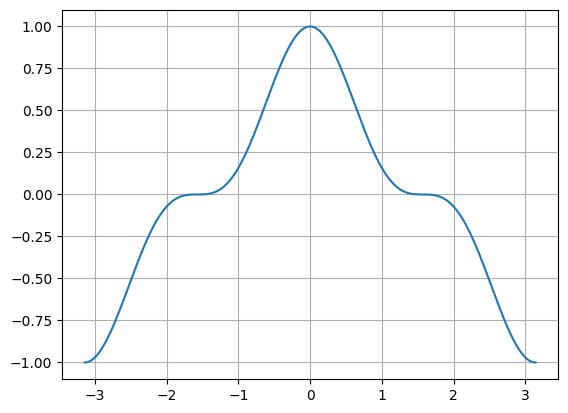

In [177]:
#True value

True_values=np.cos(k*s_0_values)**3


plt.plot(s_0_values,True_values)
plt.grid()
plt.show()



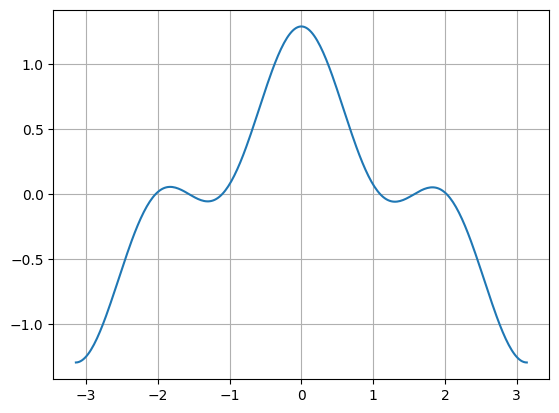

In [178]:
#solution to 1-st order PhiBE

A = np.zeros((2 * M + 1, 2 * M + 1))
b = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
        sigma=( (1/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (np.exp(lambda_*delta_t)-1)**2 * s_j**2 )/ (2* delta_t)
        A += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
        b += reward_function(s_j)*bases(s_j)

theta = np.linalg.solve(A, b)

    # Compute value function
PhiBE_1st_values = []
for s_0 in s_0_values:
    a = theta.T @ bases(s_0)
    PhiBE_1st_values.append(a.item())

plt.plot(s_0_values,PhiBE_1st_values)
plt.grid()
plt.show()

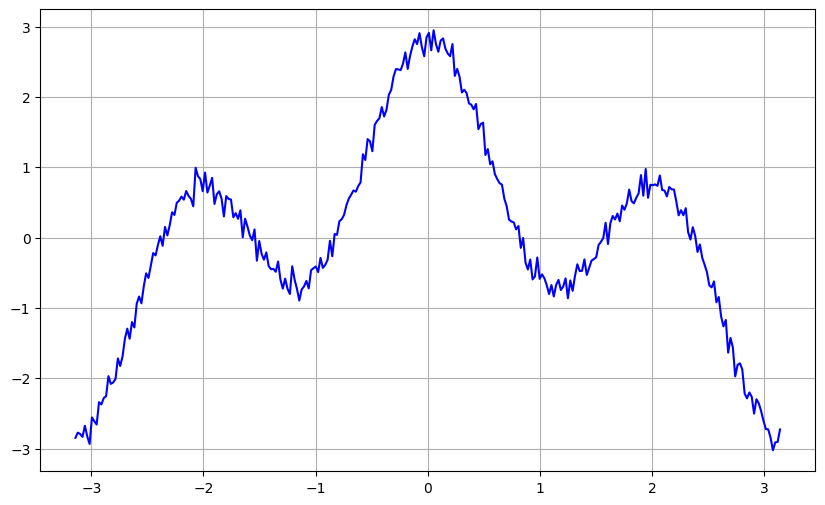

In [179]:
#solution to BE

def BE_single(s_0, num_steps):
    V_approx = 0
    s_now = s_0
    for j in range(num_steps):
        s_next = s(1,delta_t,s_now)
        V_approx += np.exp(-beta * j * delta_t) * reward_function(s_now) * delta_t
        s_now = s_next
    return V_approx

def BE_value(s_0, num_steps, num_simulations):
    results = []
    for _ in range(num_simulations):
        V = BE_single(s_0, num_steps)
        results.append(V)
    return np.mean(results)
    

BE_values = []
for x in s_0_values:
    a = BE_value(x, num_steps=300, num_simulations=20)
    BE_values.append(a)


plt.figure(figsize=(10, 6))
plt.plot(s_0_values, BE_values, color='b')
plt.grid()
plt.show()


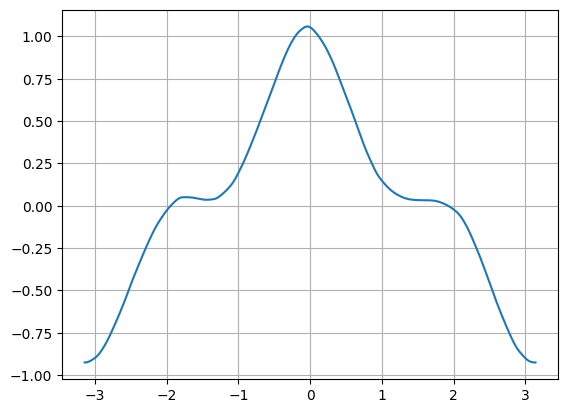

In [180]:
# Algorithm 2 for 1-st order PhiBE 
A2 = np.zeros((2 * M + 1, 2 * M + 1))
b2 = np.zeros((2 * M + 1, 1))

#mu = np.mean(delta_s_list) / delta_t
#sigma = np.mean(delta_s_squared_list) / delta_t

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu=(traj[j+1]-traj[j])/delta_t
        sigma=(traj[j+1]-traj[j])**2/delta_t
        
        A2 +=  bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma/2)  * gra_gradient_bases(s_j)).T
        b2 += reward_function(s_j) * bases(s_j)

theta2 = np.linalg.solve(A2, b2)

    # Compute value function
Galerkin_1st_values = []
for s_0 in s_0_values:
    V = theta2.T @ bases(s_0)
    Galerkin_1st_values.append(V.item())


plt.plot(s_0_values, Galerkin_1st_values)
plt.grid()
plt.show()




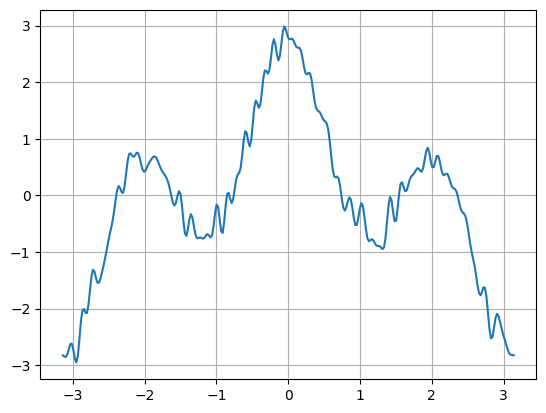

In [181]:
#LSTD to BE

A3 = np.zeros((2 * M + 1, 2 * M + 1))
b3 = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m-1):
        s_j = traj[j]
        s_j_next = traj[j+1]
        mu = (traj[j+1]-traj[j])/delta_t
        sigma = (traj[j+1]-traj[j])**2 /delta_t
        A3 += bases(s_j)@(bases(s_j) - np.exp(-beta*delta_t) * bases(s_j_next)).T 
        b3 += reward_function(s_j) * bases(s_j)*delta_t

theta3 = np.linalg.solve(A3, b3)

    # Compute value function
LSTD_values = []
for s_0 in s_0_values:
    V_LSTD = theta3.T @ bases(s_0)
    LSTD_values.append(V_LSTD.item())

plt.plot(s_0_values,LSTD_values)
plt.grid()
plt.show()


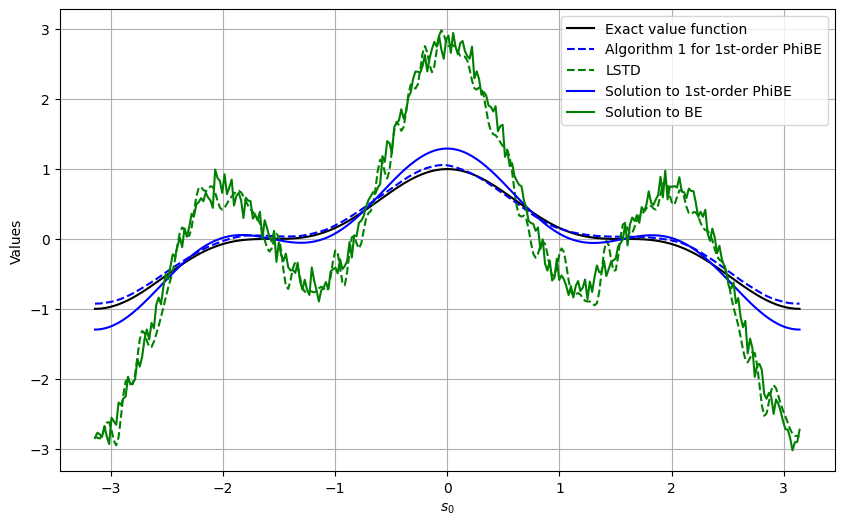

In [182]:
#plot together
plt.figure(figsize=(10, 6))

plt.plot(s_0_values, True_values, 'k-', label='Exact value function')  # 黑色实线
plt.plot(s_0_values, Galerkin_1st_values, 'b--', label='Algorithm 1 for 1st-order PhiBE')  # 蓝色虚线
plt.plot(s_0_values, LSTD_values, 'g--', label='LSTD')  # 绿色虚线
plt.plot(s_0_values, PhiBE_1st_values, 'b-', label='Solution to 1st-order PhiBE')  # 蓝色实线
plt.plot(s_0_values, BE_values, 'g-', label='Solution to BE')  # 绿色实线


plt.xlabel('$s_0$')
plt.ylabel('Values')


plt.legend()
plt.grid(True)
plt.show()